In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from scipy.stats import pearsonr
from tqdm import tqdm

In [65]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/borzoi/')

In [66]:
csv_dir = f'../results/summary_csvs/borzoi/'
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cell_line_info, cage_tracks = utils.get_borzoi_targets(target_df, cell_lines)


# TSS activity: Borzoi vs Enformer 

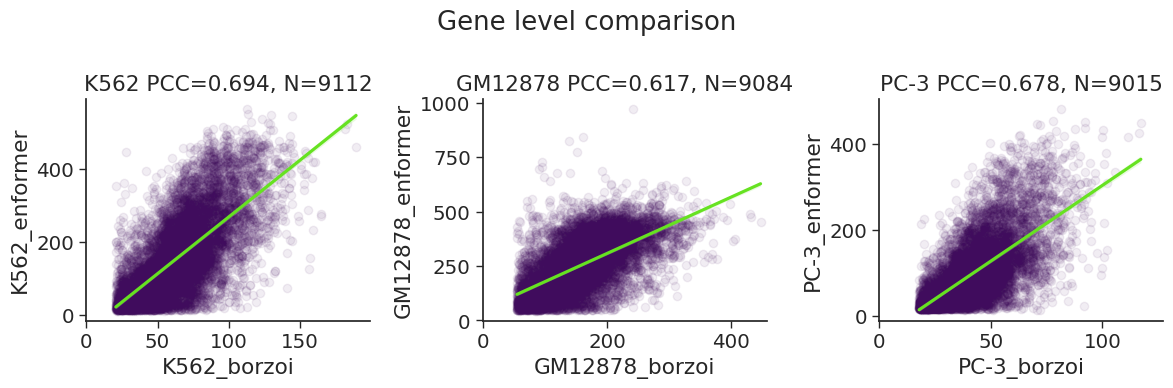

In [67]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
column_transl = {'K562 ENCODE, biol_': 'K562', 'GM12878 ENCODE, biol_': 'GM12878'}
for c, cell_line in enumerate(['K562', 'GM12878', 'PC-3']):
    ax = axes[c]
    borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{cell_line}*selected_genes.csv')[0])
    borzoi_selected_genes = borzoi_selected_genes.rename(columns=column_transl)
    enformer_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/enformer/*{cell_line}_selected_genes.csv')[0])
    borzoi_enf_merge = borzoi_selected_genes.merge(enformer_selected_genes, on=['gene_name'], suffixes=['_borzoi', '_enformer'])



    
    x=borzoi_enf_merge[f'{cell_line}_borzoi']
    y=borzoi_enf_merge[f'{cell_line}_enformer']
    sns.regplot(x=x, y=y, ax=ax, 
                scatter_kws = {"color": '#400c5d', "edgecolor": None, "alpha": 0.07},
                line_kws = {'color': "#66e221"})  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _, xmax = ax.get_xlim()
    ax.set_xlim(0, xmax+10)
    ax.set_title(f'{cell_line} PCC={np.round(pearsonr(x,y)[0], 3)}, N={borzoi_enf_merge.shape[0]}')
plt.suptitle('Gene level comparison')
fig.savefig(f"{pdf_dir}/gene_activity_comparison.pdf")
plt.tight_layout()


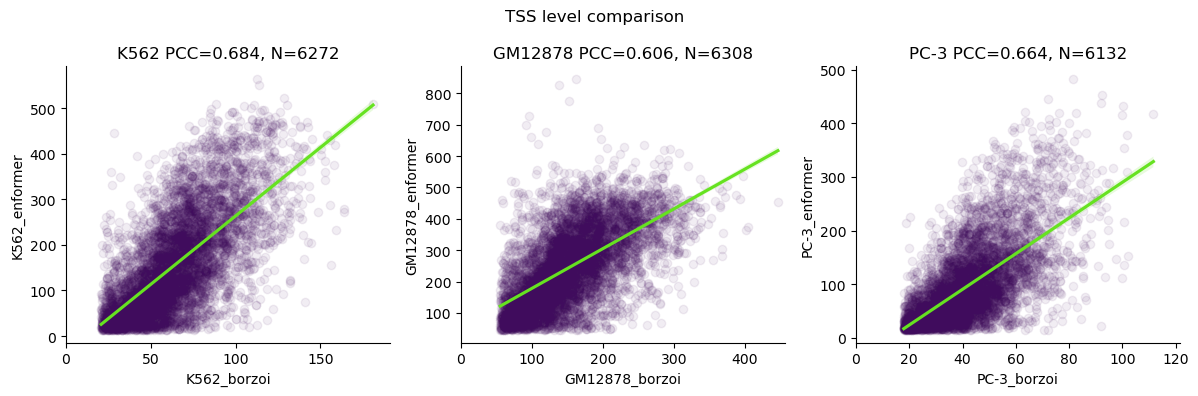

In [5]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
column_transl = {'K562 ENCODE, biol_': 'K562', 'GM12878 ENCODE, biol_': 'GM12878'}
for c, cell_line in enumerate(['K562', 'GM12878', 'PC-3']):
    ax = axes[c]
    borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{cell_line}*selected_genes.csv')[0])
    borzoi_selected_genes = borzoi_selected_genes.rename(columns=column_transl)
    enformer_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/enformer/*{cell_line}_selected_genes.csv')[0])
    borzoi_enf_merge = borzoi_selected_genes.merge(enformer_selected_genes, on=['Chromosome', 'Start'], suffixes=['_borzoi', '_enformer'])
    
    x=borzoi_enf_merge[f'{cell_line}_borzoi']
    y=borzoi_enf_merge[f'{cell_line}_enformer']
    sns.regplot(x=x, y=y, ax=ax, 
                scatter_kws = {"color": '#400c5d', "edgecolor": None, "alpha": 0.07},
                line_kws = {'color': "#66e221"})  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _, xmax = ax.get_xlim()
    ax.set_xlim(0, xmax+10)
    ax.set_title(f'{cell_line} PCC={np.round(pearsonr(x,y)[0], 3)}, N={borzoi_enf_merge.shape[0]}')
plt.suptitle('TSS level comparison')

plt.tight_layout()

# Context dependence test

In [69]:
model_name = 'borzoi'
threshold_enh, threshold_neu, threshold_sil = 0.9, 0.05, -0.2

res = []
for i, c in enumerate(cell_lines):
    deltas = []
    wt_means = []
    seq_ids = []
    selected_tss = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])
    for _, row in selected_tss.iterrows():
        path = f'../results/context_dependence_test_5/{model_name}/{utils.get_summary(row)}.pickle'
        context_res = utils.read_pickle(path)
        tss_activity = utils.read_pickle(f'../results/gencode_tss_predictions//{model_name}/{utils.get_summary(row)}.pickle')

        wt = ((tss_activity.mean(axis=0).sum(axis=-2) / 2))[:, cell_line_info[c]['output']].sum(axis=-1)
        mut = ((context_res['mut'].mean(axis=0).sum(axis=-2) / 2))[:, cell_line_info[c]['output']].sum(axis=-1)
        delta_per_model = (wt - mut) / wt
        deltas.append(delta_per_model.mean())
        wt_means.append(wt.mean())
        seq_ids.append(path)
    
        
    df = pd.DataFrame([deltas, seq_ids]).T
    df.columns = ['delta_mean', 'path']
    df['wt'] = wt_means
    df['context'] = [v for v in pd.cut(df['delta_mean'], 
                                       [df['delta_mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta_mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell_line'] = c.split()[0]
    
    print(df.shape)
    res.append(df)

res = pd.concat(res)
    

(10000, 5)
(10000, 5)
(10000, 5)


In [70]:
selected_contexts = res[[True if c in ['enhancing', 'neutral', 'silencing'] else False for c in res['context']]]

In [71]:
selected_contexts.groupby(['cell_line', 'context']).count()

delta_mean  path   wt
cell_line context                         
GM12878   enhancing         113   113  113
          neutral            54    54   54
          silencing          12    12   12
K562      enhancing         204   204  204
          neutral            61    61   61
          silencing          17    17   17
PC-3      enhancing          71    71   71
          neutral            63    63   63
          silencing          13    13   13

In [9]:
for cell_line, df in selected_contexts.groupby('cell_line'):
    df.to_csv(f'../results/summary_csvs/borzoi/{cell_line}_selected_contexts.csv')

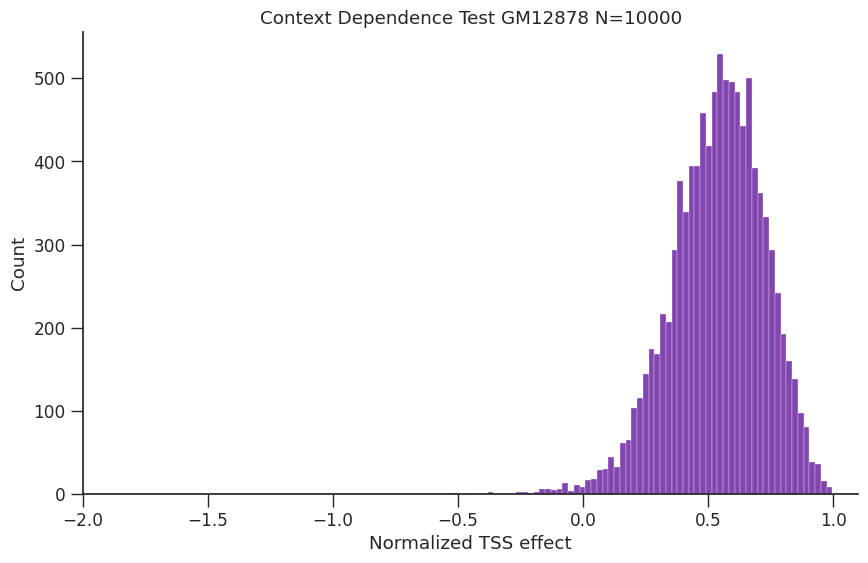

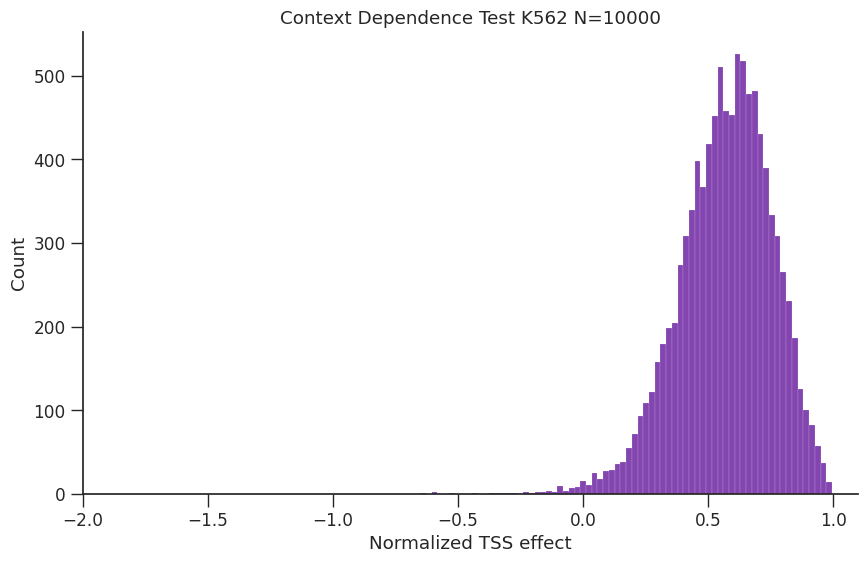

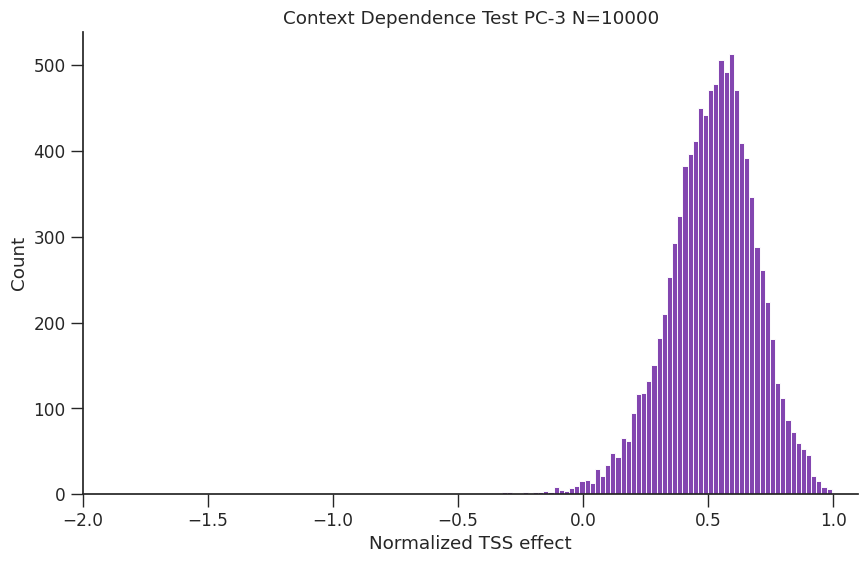

In [73]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell_line'):
    # df = df[(df['delta_mean'] > -10) & (df['wt'] > 3)]
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta_mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.xlim([-2,1.1])
    # plt.xticks([-2, -1, 0, 1])
    # plt.yticks([100, 200, 300])
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f"{pdf_dir}/context_dependence_test_{k}.pdf")

    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Select enhancing, silencing and neutral contexts

(113, 5)
(54, 5)
(12, 5)
['enhancing (N=113)', 'neutral (N=54)', 'silencing (N=12)']
(204, 5)
(61, 5)
(17, 5)
['enhancing (N=200)', 'neutral (N=61)', 'silencing (N=17)']
(71, 5)
(63, 5)
(13, 5)
['enhancing (N=71)', 'neutral (N=63)', 'silencing (N=13)']


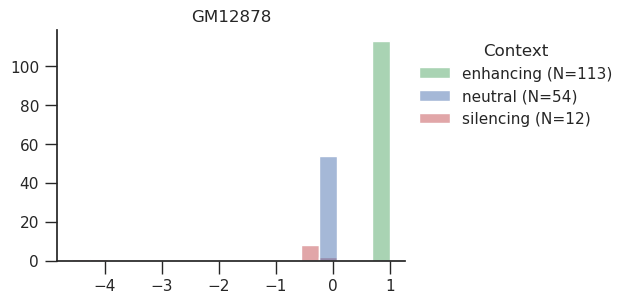

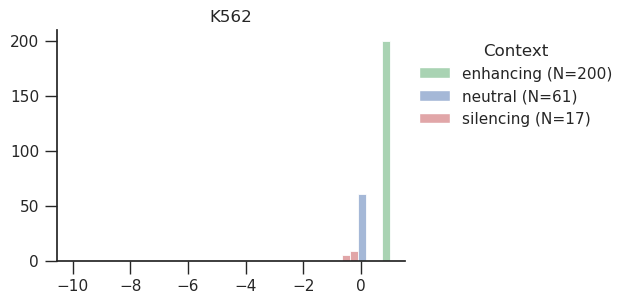

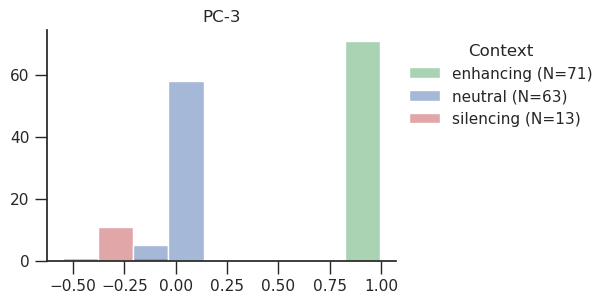

In [74]:
max_sample_size = 200
for k, df in res.groupby('cell_line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    fig.savefig(f"{pdf_dir}/context_stratification_{k}.pdf")

    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # context_df.to_csv(f'../results/summary_csvs//{model_name}/{k.split()[0]}_selected_contexts.csv')


In [75]:
summary_combined = res.reset_index(drop=True)
summary_combined.to_csv(f'{csv_dir}/context_dependence_test.csv') # summary of context effect for every selected gene


# Sufficiency test

In [12]:
context_dfs_per_cell = {}
for cell_line in cell_lines:
    df = pd.read_csv(f'../results/summary_csvs/borzoi/{cell_line.split()[0]}_selected_contexts.csv')
    df['seq_id'] = [r.split('.')[-2].split('/')[-1] for r in df['path']]

    context_dfs_per_cell[cell_line.split()[0]] = df

In [18]:
tile_df = pd.read_csv('../results/summary_csvs/borzoi/sufficiency_test_tile_coordinates.csv').T.iloc[1:-1,:]
cell_lines_dict = {'K562': 'K562 ENCODE, biol_', 'GM12878': 'GM12878 ENCODE, biol_', 'PC-3': 'PC-3'}


In [26]:
result_summary = []
for cell_line, df in context_dfs_per_cell.items():
    track_index = cell_line_info[cell_lines_dict[cell_line]]['output']
    for i, row in df.iterrows():
        res = utils.read_pickle(f'../results/sufficiency_test/borzoi/{row["seq_id"]}.pickle')
        res['wt'] = (res['wt'].sum(axis=0) / 2)[track_index].sum()
        res['control'] = res['control'][:,:,track_index].sum(axis=-1).sum(axis=-1) / 2
        res['mut'] = res['mut'][:,:,track_index].sum(axis=-1).sum(axis=-1) / 2

        one_seq = pd.DataFrame((res['mut']-res['control']) / res['wt'])
        one_seq.columns = ['(MUT - CONTROL) / WT']
        one_seq['(MUT - CONTROL) / CONTROL'] = (res['mut']-res['control']) / res['control']
        one_seq['seq_id'] = row['seq_id']
        one_seq['control'] = res['control']
        one_seq['wt'] = res['wt']
        one_seq['mut'] = res['mut']
        one_seq['tile_start'] = tile_df[0].values
        one_seq['tile_end'] = tile_df[1].values
        one_seq['context'] = row['context']
        one_seq['cell_line'] = cell_line
        result_summary.append(one_seq)
result_summary = pd.concat(result_summary)
result_summary.to_csv('../results/summary_csvs/borzoi/sufficiency_test.csv')

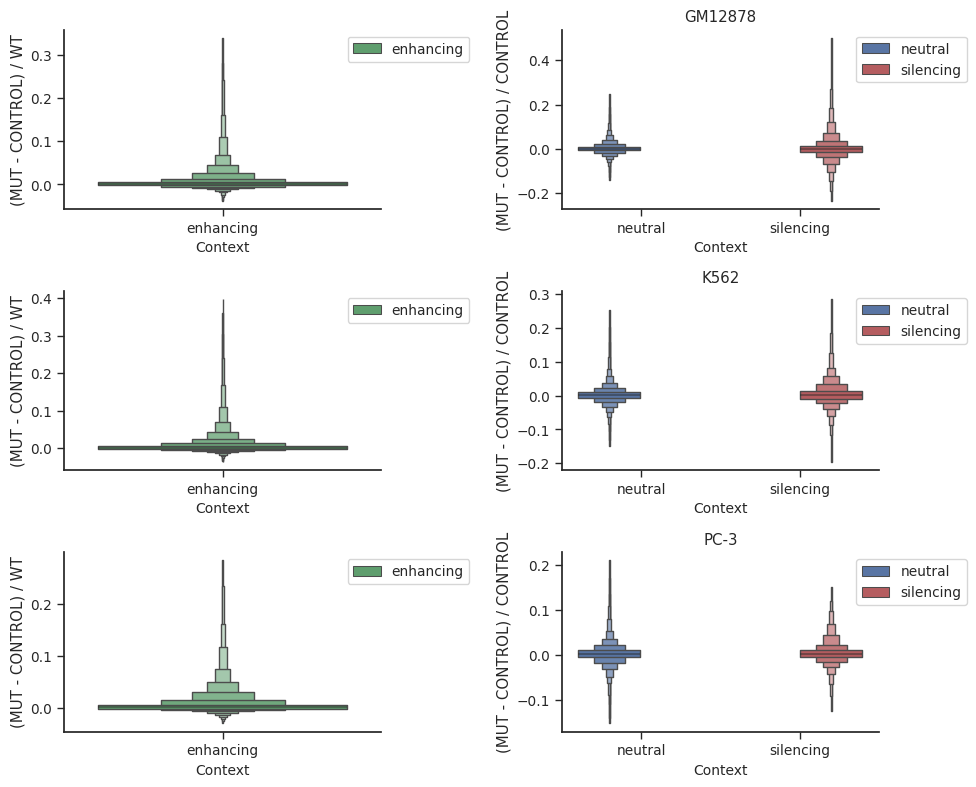

In [76]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(3, 2, figsize=[10, 8])

for c, (cell, df) in enumerate(result_summary.groupby('cell_line')):
    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others.sort_values('context'), '(MUT - CONTROL) / CONTROL']]):
        ax = axes[c, p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
                      hue='context',
                      ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
                
        ax.legend(bbox_to_anchor=[1.3,1])
    axes[c, 1].set_title(cell)

plt.tight_layout()
fig.savefig(f'{pdf_dir}/sufficiency_test.pdf')


# Select sufficient CREs

In [27]:
result_summary = pd.read_csv('../results/summary_csvs/borzoi/sufficiency_test.csv')

In [30]:
selected_cres = []
for cell, df in result_summary.groupby('cell_line'):
    enh_cont_df = (df[df['context'] == 'enhancing']).copy()  # only select enhancing CREs in enhancing contexts
    sil_cont_df = (df[(df['context'] == 'neutral') | (df['context'] == 'silencing')]).copy()  # only select silencing CREs in silencing contexts
    enh_cont_df['Normalized CRE effect'] = enh_cont_df[
        '(MUT - CONTROL) / WT']  # different norm for tiles from enh vs sil
    sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']

    enh_cres = (enh_cont_df[(enh_cont_df['Normalized CRE effect'] > 0.3)]).copy()
    enh_cres['tile class'] = 'Enhancer'
    selected_cres.append(enh_cres)
    sil_cres = (sil_cont_df[(sil_cont_df['Normalized CRE effect'] < -0.15)]).copy()
    sil_cres['tile class'] = 'Silencer'
    selected_cres.append(sil_cres)
selected_cres = pd.concat(selected_cres)
selected_cres[selected_cres['cell_line']=='K562'].to_csv('../results/summary_csvs/borzoi/sufficient_CREs.csv')
# selected_cres.to_csv(f'{csv_dir}/sufficient_CREs.csv')

In [31]:
selected_cres.groupby(['cell_line', 'tile class']).count()

Unnamed: 0  (MUT - CONTROL) / WT   
cell_line tile class                                     
GM12878   Enhancer             8                     8  \
          Silencer            21                    21   
K562      Enhancer            21                    21   
          Silencer            16                    16   
PC-3      Enhancer             6                     6   
          Silencer             9                     9   

                      (MUT - CONTROL) / CONTROL  seq_id  control  wt  mut   
cell_line tile class                                                        
GM12878   Enhancer                            8       8        8   8    8  \
          Silencer                           21      21       21  21   21   
K562      Enhancer                           21      21       21  21   21   
          Silencer                           16      16       16  16   16   
PC-3      Enhancer                            6       6        6   6    6   
          Silencer                            9       9        9   9    9   

                      tile_start  tile_end  context  Normalized CRE effect  
cell_line tile class                                                        
GM12878   Enhancer             8         8        8                      8  
          Silencer            21        21       21                     21  
K562      Enhancer            21        21       21                     21  
          Silencer            16        16       16                     16  
PC-3      Enhancer             6         6        6                      6  
          Silencer             9         9        9                      9

# Sufficient tile distribution

In [32]:
tss_tile = pd.read_csv('../results/summary_csvs/borzoi/sufficiency_test_tile_coordinates.csv').T.iloc[-1,:]

In [33]:
selected_cres['tile start relative to tss'] =  np.abs(selected_cres['tile_start'] - tss_tile[0]) // 1000


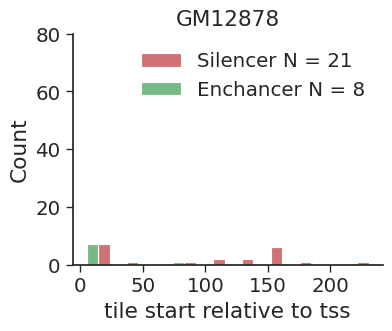

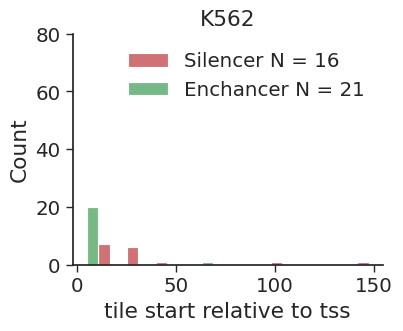

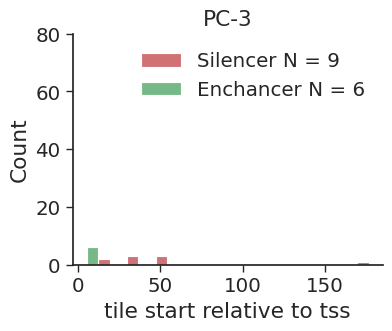

In [34]:
sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in selected_cres.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    # fig.savefig(f'{pdf_dir}/{cell}_CRE_frequency_vs_distance.pdf')
    plt.show()

# Distance test

In [38]:
borzoi_model_seq_length = 524288
cre_df = pd.read_csv(f'../results/summary_csvs/borzoi/sufficient_CREs.csv')
tss_tile, cre_tiles = utils.set_tile_range(borzoi_model_seq_length, 5000)

cre_tiles_starts = np.array(cre_tiles).T[0]
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000
cre_df.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df['tile_start'].values ])


In [36]:
test_results = f'../results/distance_test_True/borzoi_5/'

In [37]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cell_lines_for_search = ['K562 ENCODE, biol_']

cell_line_info, track_index = utils.get_borzoi_targets(target_df, cell_lines_for_search)


In [63]:
normalized_tests = []
for j, (_, row) in tqdm(enumerate(cre_df.iterrows())):
    tile_start, tile_end = [row['tile_start'], row['tile_end']]
    result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
    res = utils.read_pickle(result_path)    
    test = (res['mut'].mean(axis=1).sum(axis=1)/2).sum(axis=-1)
    control = row['control']
    if row['context'] == 'enhancing':
        CRE_norm_effects = (test - control) / row['wt']
    else:
        CRE_norm_effects = (test - control) / control
    # norm_effects = test / control
    norm_effects = test / np.max(test)
    # normalized_tests.append(norm_effects)
    df = pd.DataFrame([norm_effects, CRE_norm_effects, cre_tiles_starts_abs]).T
    df.columns = ['Fold change over control', 'CRE sufficiency effect', 'Binned distance (Kb)']


    df['tile class'] = row['tile class']
    df['cell line'] = 'K562'
    df['seq_id'] = row['seq_id']
    normalized_tests.append(df)

result_normalized_effects = pd.concat(normalized_tests)


37it [00:00, 574.92it/s]


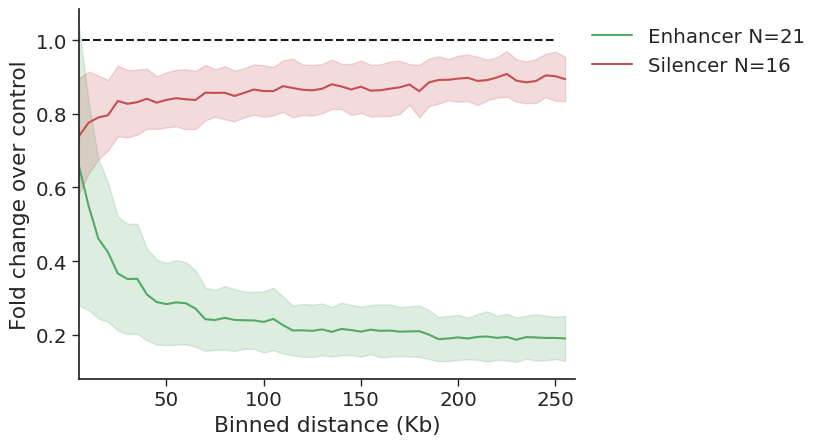

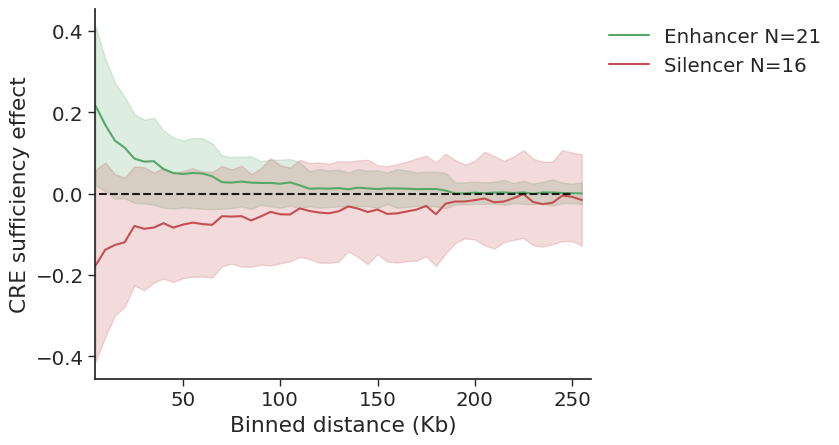

In [64]:

n_df = result_normalized_effects.groupby(['tile class']).count()
n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
my_palette = {}
tile_labels = {}
for i, row in n_df.iterrows():
    c = 'g' if i=='Enhancer' else 'r'
    my_palette[f'{i} N={row.iloc[0]//len(cre_tiles_starts_abs)}'] = c
    k = 'Enhancer' if 'Enh' in i else 'Silencer'
    tile_labels[k] = f'{i} N={row.iloc[0]//len(cre_tiles_starts_abs)}'
result_normalized_effects['tile class'] = [tile_labels[t] for t in result_normalized_effects['tile class']]


for y, hline_y, filename_label in [['Fold change over control', 1, 'fold_change'], ["CRE sufficiency effect", 0, 'cre_effect']]:

    
    ax=sns.lineplot(data=result_normalized_effects, x='Binned distance (Kb)', 
                    y=y, hue='tile class', ci='sd',
                  palette=my_palette)
    ax.hlines(hline_y, 1, 250, color='k', linestyle='--')
    ax.set_xlim([5, 260])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.title(cell_line)
    
    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.savefig()
    plt.show()